# Configuration du notebook

In [95]:
# Data analysis libraries
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from wordcloud import WordCloud

# Image processing library
from PIL import Image

# Text processing libraries
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cramarokoto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:
# Chargement des données
X_train = pd.read_csv("./../data/X_train_update.csv", index_col=0)
y_train = pd.read_csv("./../data/Y_train_CVw08PX.csv", index_col=0)
X_test = pd.read_csv("./../data/X_test_update.csv", index_col=0)

In [97]:
def data_info(df, name):
    df.info()
    print("\n")
    display(df.head())
    print("\n")


Paths of splitted images folder:

In [98]:
# Paths
image_train_path = "./../data/images/image_train/"
image_test_path = "./../data/images/image_test/"

Useful functions:

In [99]:
# Find a picture path from its imageid and its productid
def image_path(imageid, productid, split="train"):
    if split == "train":
        path = image_train_path
    elif split == "test":
        path = image_test_path
    else:
        raise Exception("split must be train or test.")

    image_path = path + "image_" + str(imageid) + "_product_" + str(productid) + ".jpg"
    return image_path


# display a picture from its imageid and its productid
def display_image(imageid, productid, split="train"):
    img = mpimg.imread(image_path(imageid, productid, split))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return


### SHOULD WE ADD A PATH TO PICTURE COLUMN TO THE DATAFRAMES ?
# display a picture from a textual row
def display_from(index_or_row, split="train", is_index=True):
    """
    Display a picture from index (is_index must be True) or
    row number (is_index must be False) of the considered split.
    """
    if split == "train":
        df = X_train
    elif split == "test":
        df = X_test
    else:
        raise Exception("split must be train or test.")
        
    if is_index:
        display_image(df.loc[index_or_row, "imageid"], df.loc[index_or_row, "productid"], split)
    else:
        display_image(df.iloc[index_or_row, 3], df.iloc[index_or_row, 2], split)
    return

# Exploration des données

First things to understand about data:

- X_train contains all data that we have to train AND test: associated with y_train values.
- X_test contains only data to classify with our model in order to be evaluated for the Rakuten challenge.
- Same context for images.

|        | Nombre lignes dans la table : ? | 84916                                                                                                             | Pour le dataset utilisable                                                                                                                       |                                                                                                                      |            |                                                                                                                                                                                                                                           |                                                                                                                                                                                                      |                                                                                  |
|--------|---------------------------------|-------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------|------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| N° Col | Nom de la colonne               | Description                                                                                                       | Disponibilité de la variable a priori                                                                                                            | Type informatique                                                                                                    | Taux de NA | Gestion des NA                                                                                                                                                                                                                            | Distribution des valeurs                                                                                                                                                                             | Remarques sur la colonne                                                         |
|        |                                 | Que représente cette variable en quelques mots ?                                                                  | Pouvez vous connaitre ce champ en amont d'une prédiction ? Aurez vous accès à cette variable en environnement de production ?                    | int64, float etc...  Si "object", détaillez.                                                                         | en %       | Quelle mode de (non) - gestion des NA favorisez vous ?                                                                                                                                                                                    | Pour les variables catégorielles comportant moins de 10 catégories, énumérez toutes les catégories.  Pour les variables quantitatives, détaillez la distribution (statistiques descriptives de base) | champs libre à renseigner                                                        |
| 1      | Désignation                     | L’appelation du produit : comme une petite description qui donne l’essentiel sur le produit et donc sa catégorie. | Cette donnée est la base textuelle et est toujours accessible pour la prédiction même en environnement de production.                            | «object » qui est clairement une chaîne de caractères. Certains symboles doivent être changés pour la compréhension. | 0,00 %     | /                                                                                                                                                                                                                                         | C’est un string qui n’est ni quantitatif ni catégoriel. C’est une variable descriptive.                                                                                                              | Les valeurs d’un tel string sont très vastes et une analyse NLP sera nécessaire. |
| 2      | Description                     | Description plus détaillé du produit, de son état, de son utilisation. Regorge d’informations et de mots clés.    | Cette donnée est accessible pour la prédiction même en environnement de production, seulement quand elle n’est pas n/a (nombreuses occurrences). | «object » qui est clairement une chaîne de caractères. Certains symboles doivent être changés pour la compréhension. | 35.09%     | Il s’agit d’une description textuelle : on ne peut la générer pertinemment ni effectuer un remplissage statistique. Soit on l’utilise seulement lorsqu’elle est présente ; soit on fait un remplissage par IA à partir de la désignation. | Identique à la désignation à l’exception des nombreux N/A.                                                                                                                                           | Identique à la désignation.                                                      |
| 3      | productid                       | L’index du produit                                                                                                | N’aura pas de valeur pour être entraîné autre que pour relier le produit (textuel) à son image                                                   | int64                                                                                                                | 0,00 %     | /                                                                                                                                                                                                                                         | /                                                                                                                                                                                                    | /                                                                                |
| 4      | imageid                         | L’index de l’image                                                                                                | N’aura pas de valeur pour être entraîné autre que pour relier le produit (textuel) à son image                                                   | int64                                                                                                                | 0,00 %     | /                                                                                                                                                                                                                                         | /                                                                                                                                                                                                    | /                                                                                |
| 5      | imagepath                       | Le path de l’image pour l’associer au produit                                                                     | Utile en prod pour entraîner sur l’image tout en ayant la bonne évaluation de la classe                                                          | string                                                                                                               | 0.00%      | /                                                                                                                                                                                                                                         | /                                                                                                                                                                                                    | /                                                                                |

## Description de X_train

In [100]:
data_info(X_train, "X_train")

#### Nan values in X_train ####

print("NaN values in X_train")
X_train_nan = X_train.isna().sum()
print(X_train_nan)
print("\n")

print("Nan values ratio in X_train", X_train_nan / len(X_train))

#### Unique values in train variables ####

print("Unique value numbers in train variables :", end = "\n\n")
print(X_train.nunique(), end = "\n\n")

# Less unique values in Designation than productid and imageid -> Duplicates with different id ?

#### Duplicated values in train variables ####

print("# of duplicates in designation :", round(X_train.duplicated(subset = ["designation"]).sum()/len(X_train["designation"])*100, 2), "%")
print("# of duplicates in productid :", X_train.duplicated(subset = ["productid"]).sum())
print("# of duplicates in imageid :", X_train.duplicated(subset = ["imageid"]).sum())

# Duplicates of products with different productid and imageid

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB




,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786




NaN values in X_train
designation        0
description    29800
productid          0
imageid            0
dtype: int64


Nan values ratio in X_train designation    0.000000
description    0.350935
productid      0.000000
imageid        0.000000
dtype: float64
Unique value numbers in train variables :

designation    82265
description    47506
productid      84916
imageid        84916
dtype: int64

# of duplicates in designation : 3.12 %
# of duplicates in productid : 0
# of duplicates in imageid : 0


Conformément à la description des données, seule la description est optionnelle, on remarque que le jeu de données est complet et que c'est la seule variable avec des valeurs nulles.

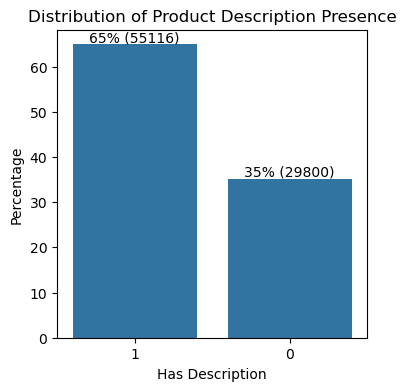

In [101]:
# Dichotomisation de la présence de description dans X_train
X_train['has_description'] = X_train['description'].notna().astype(int)

abs_values = X_train['has_description'].value_counts(ascending=False)
rel_values = X_train['has_description'].value_counts(ascending=False, normalize=True).values * 100
labels = [f'{p[1]:.0f}% ({p[0]})' for p in zip(abs_values, rel_values)]

# Affichage de la distribution de has_description
plt.figure(figsize=(4, 4))
ax = sns.countplot(data=X_train, x='has_description', order=X_train['has_description'].value_counts().index, stat='percent')
ax.bar_label(container=ax.containers[0], labels=labels)

plt.title('Distribution of Product Description Presence')
plt.xlabel('Has Description')
plt.ylabel('Percentage')
plt.show()

Il y a plus de produits avec une description (65 %) que de produits sans description (35%) malgré le caractère optionnel de la description. On peut supposer que cela est dû à l'importance de la description de l'article pour favoriser sa vente en plus de sa catégorisation. En effet, la description fournit d'autres éléments discriminant pour un produit dans le cadre de la recherche via un moteur parmi de nombreux produits.

## Description de y_train

In [102]:
data_info(y_train, "y_train")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   prdtypecode  84916 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB




,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


In [103]:
# Nombre de valeurs uniques dans y_train
print("Unique values in y_train")
print(y_train.nunique())

Unique values in y_train
prdtypecode    27
dtype: int64


Il existe 27 classes de produits distinctes dans le jeu de données d'apprentissage.

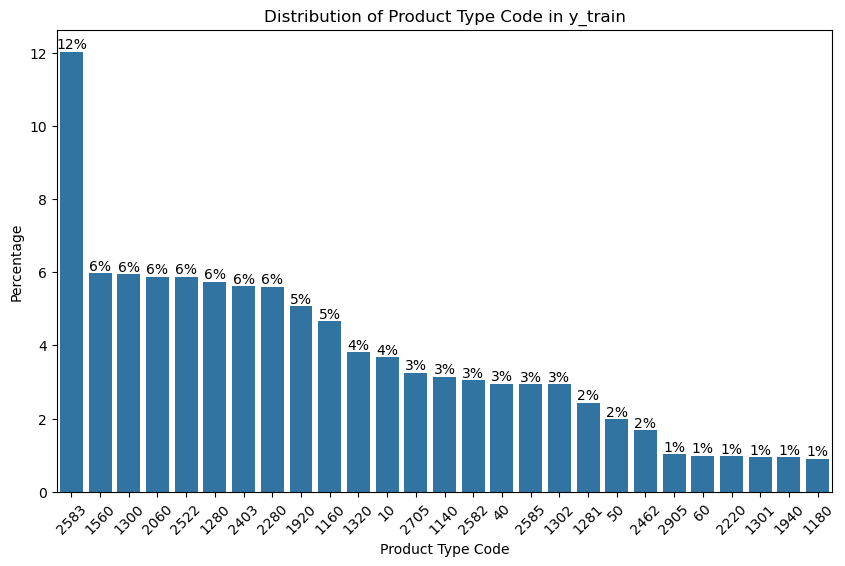

In [104]:
abs_values = y_train['prdtypecode'].value_counts(ascending=False)
rel_values = y_train['prdtypecode'].value_counts(ascending=False, normalize=True).values * 100
labels = [f'{p[1]:.0f}%' for p in zip(abs_values, rel_values)]

# Histogramme de la distribution des codes de type de produit dans y_train
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=y_train, x='prdtypecode', order=y_train['prdtypecode'].value_counts().index, stat='percent')
ax.bar_label(container=ax.containers[0], labels=labels)

plt.title('Distribution of Product Type Code in y_train')
plt.xlabel('Product Type Code')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

Le jeu de données n'est pas équilibré :
- la classe 2583 est plus représentée que les autres avec 12% du jeu de données
- les classes 1560, 1300, 2060, 2522, 1280, 2403, 2280 suivent ensuite avec 6% chacune seulement
- les classes les moins représentées (2905, 60, 2220, 1301, 1940, 1180) représentent quant à elles 1% chacune

## Analyse des variables disponibles

### Analyse croisée entre la présence de 'description' du produit et la catégorie du produit


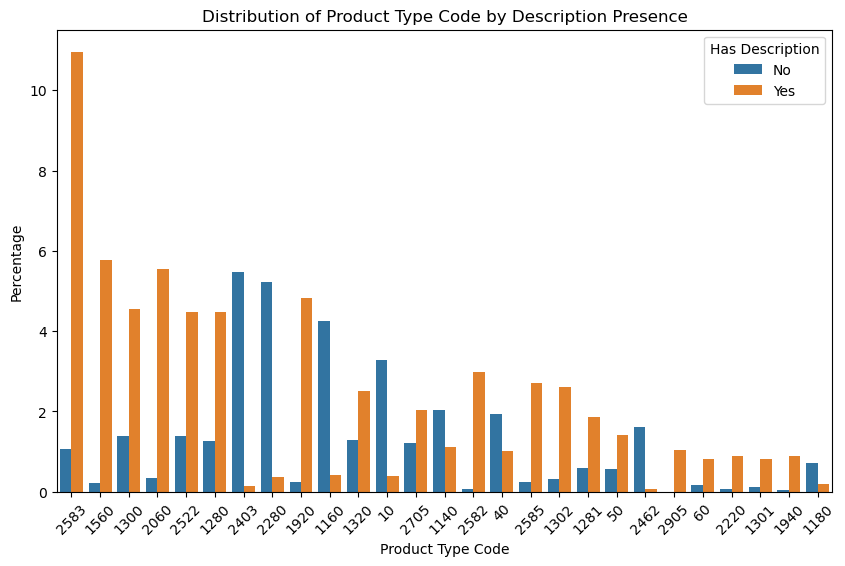

In [105]:
# Affichage de la distribution des codes de type de produit en fonction de la présence de description
plt.figure(figsize=(10, 6))
sns.countplot(data=y_train, x='prdtypecode', hue=X_train['has_description'], order=y_train['prdtypecode'].value_counts().index, stat='percent')
plt.title('Distribution of Product Type Code by Description Presence')
plt.xlabel('Product Type Code')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Has Description', loc='upper right', labels=['No', 'Yes'])
plt.show()

La répartition de produits avec ou sans description n'est pas homogène entre les catégories de produit par rapport au ratio moyen du jeu de données (65% avec et 35% sans description).
Certains produits comme 2403 contiennent majoritairement des produits non décrits alors que d'autres comme 1560 contiennent majoritairement des produits décrits.

### Analyse de la longueur de la variable 'designation'


Text(0.5, 0, 'Designation Length')

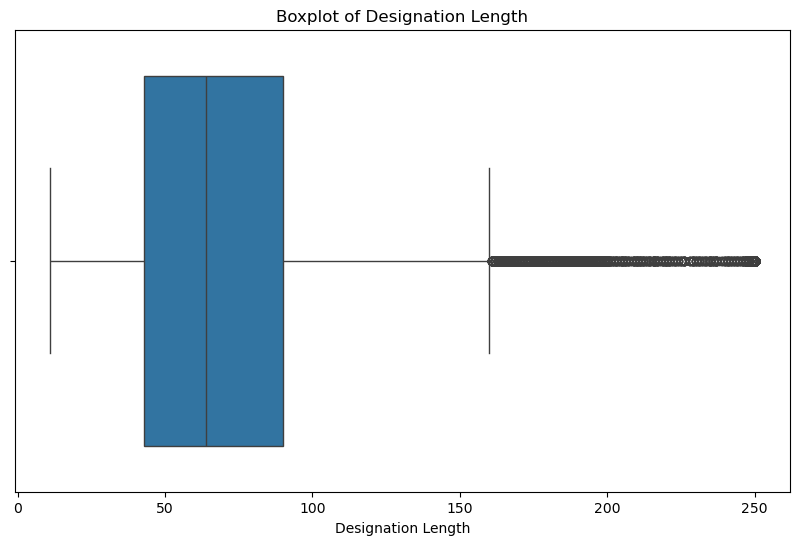

In [106]:
X_train['designation_length'] = X_train['designation'].str.len()

# Boxplot de la longueur de la variable 'designation'
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train, x='designation_length')

plt.title('Boxplot of Designation Length')
plt.xlabel('Designation Length')

In [107]:
X_train['designation_length'].describe()

count    84916.000000
mean        70.163303
std         36.793383
min         11.000000
25%         43.000000
50%         64.000000
75%         90.000000
max        250.000000
Name: designation_length, dtype: float64

On observe que la longueur de designation est très variable avec un min de 11 caractères et un max de 250 caractères.
Sa longueur moyenne est de 70 caractères et la médiane se situe à 64 caractères.
D'après le boxplot, il existe beaucoup d'outliers au dela de 160 caractères.

### Analyse croisée de la catégorie et de la longueur de la 'designation'

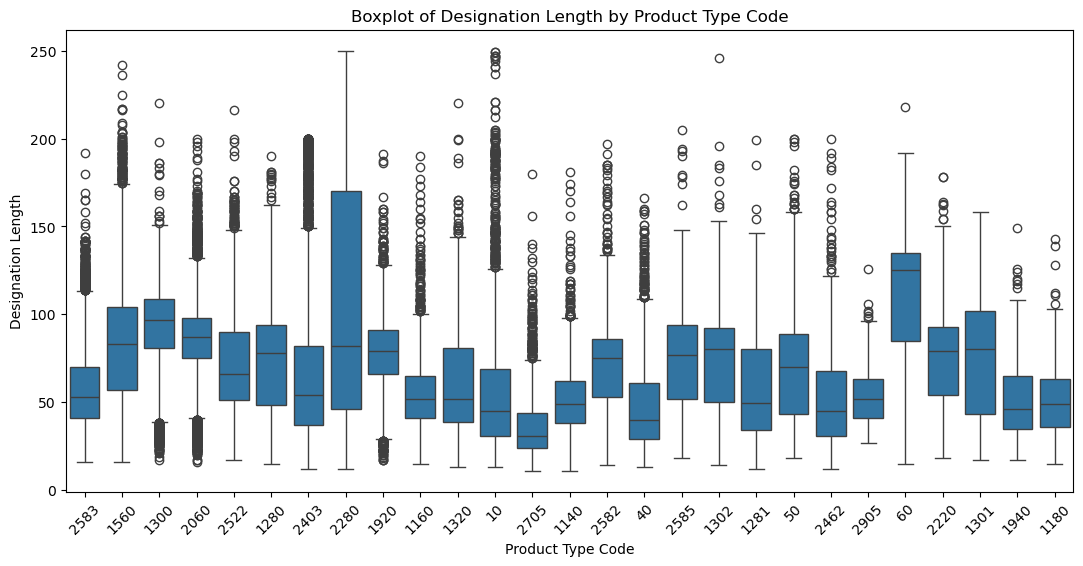

In [108]:
# Boxplot de la longueur de la variable 'designation' par catégorie de produit
plt.figure(figsize=(13, 6))
sns.boxplot(x=y_train['prdtypecode'], y=X_train['designation_length'], order=y_train['prdtypecode'].value_counts().index)
plt.title('Boxplot of Designation Length by Product Type Code')
plt.xlabel('Product Type Code')
plt.ylabel('Designation Length')
plt.xticks(rotation=45)
plt.show()

La distribution de la longueur de Designation par catégorie de produit n'est pas homogène.

### Analyse des duplicats de 'designation'

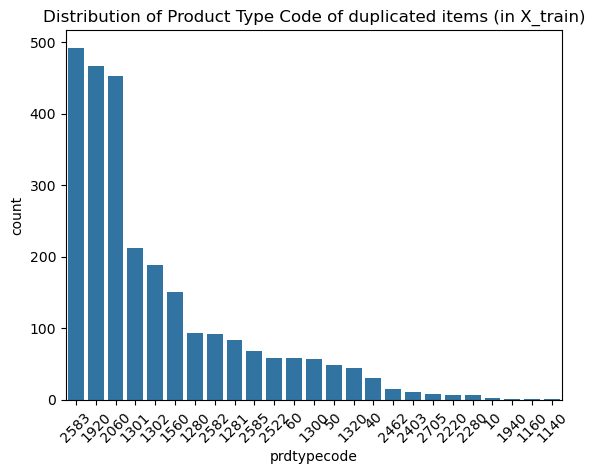

In [109]:
#### Duplicated values' categories

y_duplicated = y_train[X_train.duplicated(subset = ["designation"]) == True]

sns.countplot(data = y_duplicated, x = 'prdtypecode', order = y_duplicated['prdtypecode'].value_counts().index)
plt.xticks(rotation = 45)
plt.title("Distribution of Product Type Code of duplicated items (in X_train)")
plt.show()

### Analyse de la longueur de la variable 'description'


Text(0.5, 0, 'Description Length')

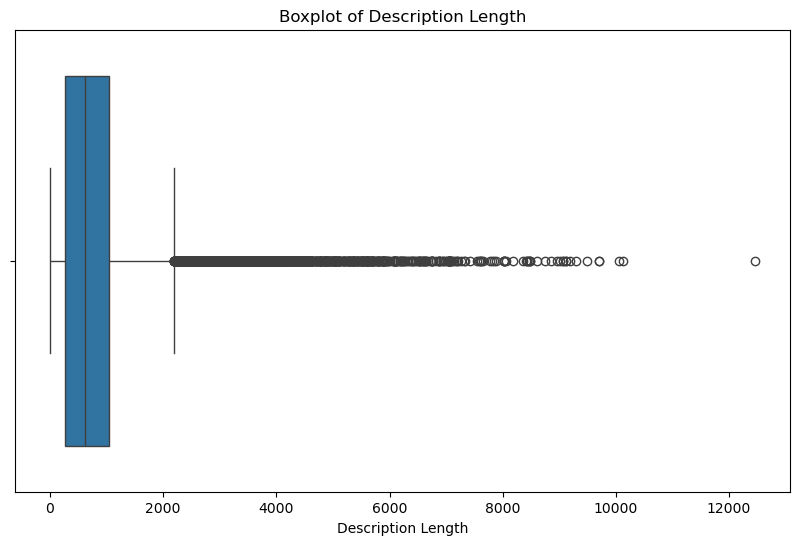

In [110]:
X_train['description_length'] = X_train['description'].str.len()

# Boxplot de la longueur de la variable 'descpription'
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train, x='description_length')

plt.title('Boxplot of Description Length')
plt.xlabel('Description Length')

In [111]:
X_train['description_length'].describe()

count    55116.000000
mean       808.171692
std        805.462153
min          1.000000
25%        259.000000
50%        626.000000
75%       1034.000000
max      12451.000000
Name: description_length, dtype: float64

On observe que la longueur de description est très variable avec un min de 1 caractères et un max de 12451 caractères.
Sa longueur moyenne est de 808 caractères et la médiane se situe à 626 caractères.
D'après le boxplot, il existe beaucoup d'outliers au dela de 2000 caractères.

### Analyse de la 'description' par catégorie de produit

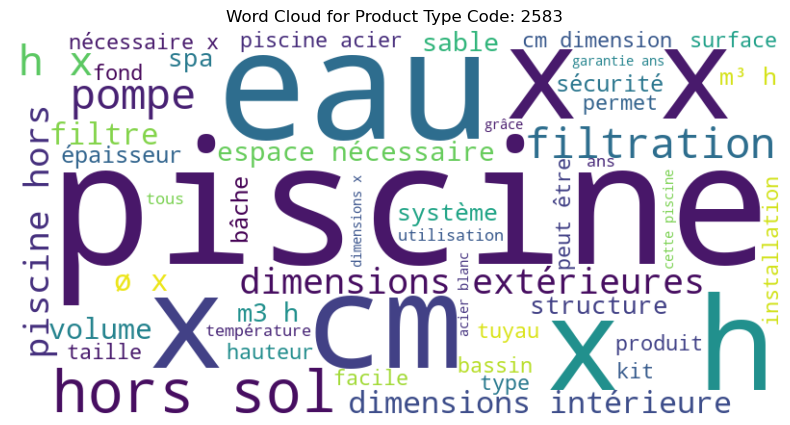

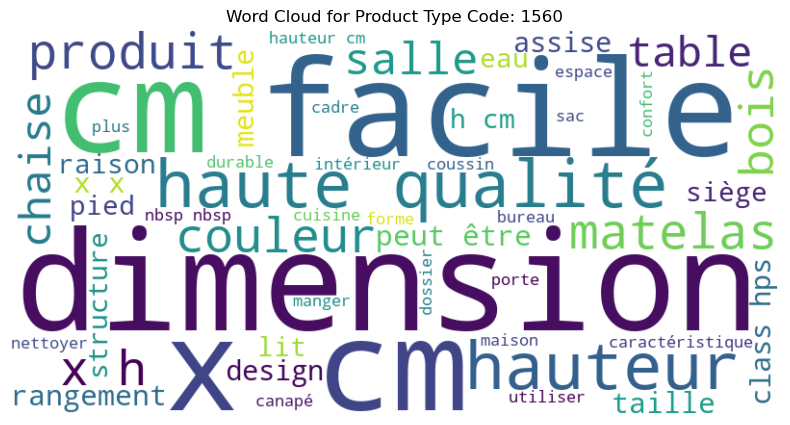

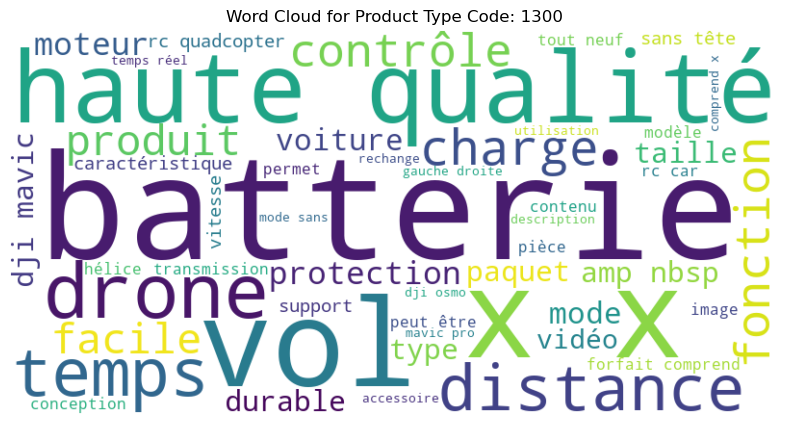

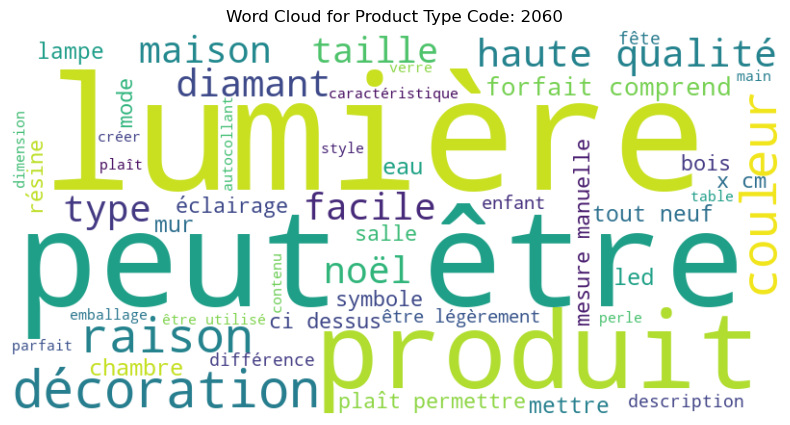

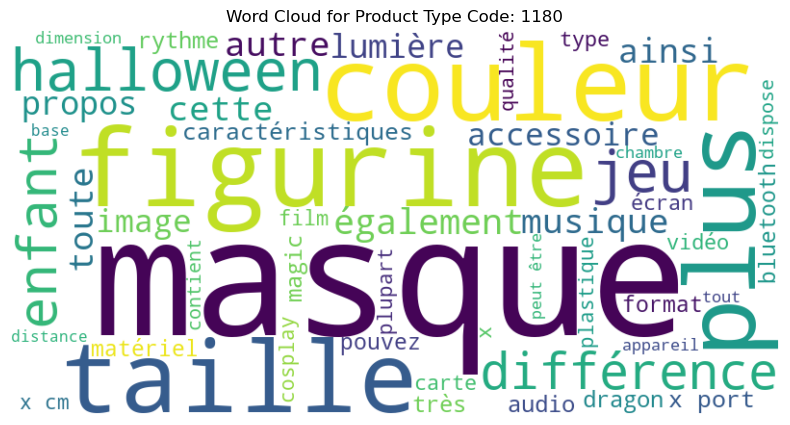

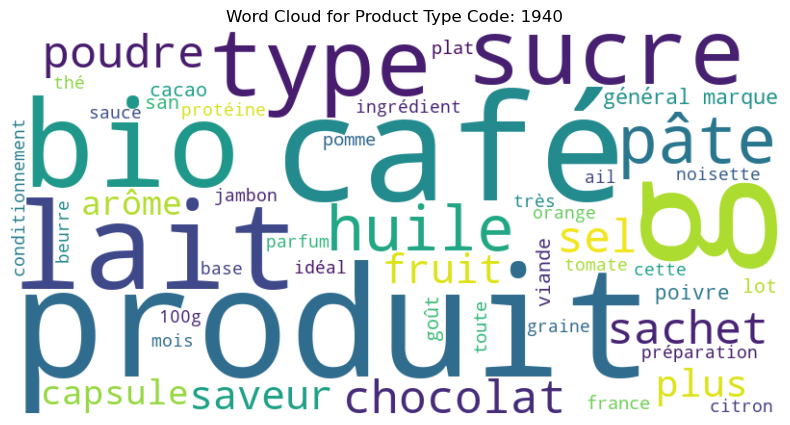

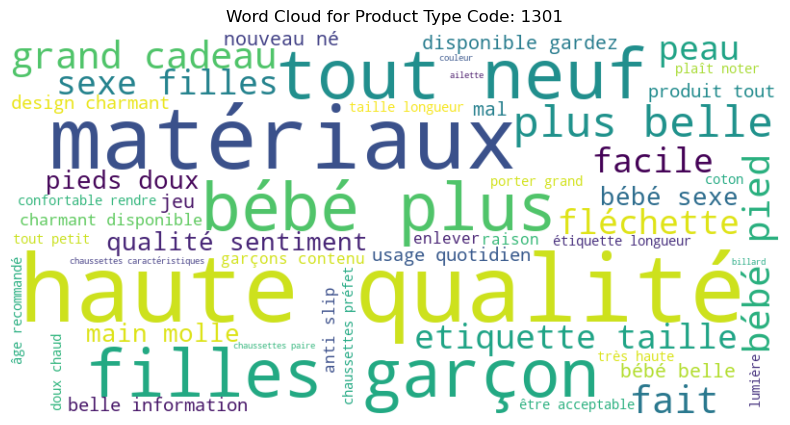

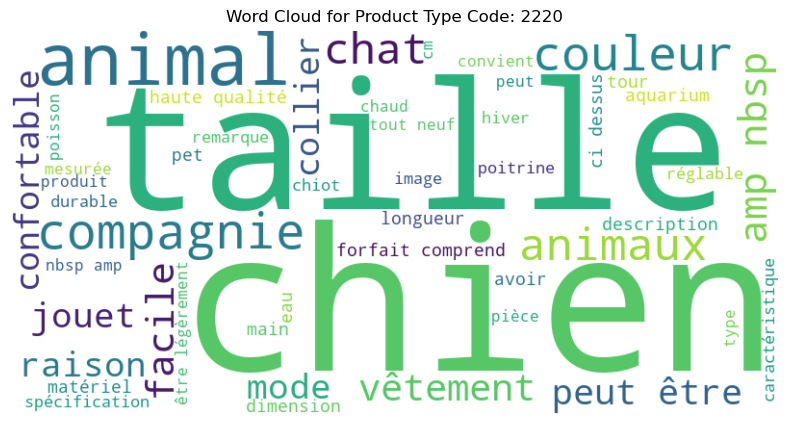

In [112]:
html_stopwords = ['br', 'p', 'div', 'span', 'b', 'i', 'li', 'ul', 'strong', 'em']
final_stopwords = stopwords.words('english') + stopwords.words('french') + html_stopwords

# Récupération des 4 catégories de produits avec le plus et le moins de descriptions pour comparaison
most_descriptions = y_train['prdtypecode'].value_counts().nlargest(4).index.tolist()
least_descriptions = y_train['prdtypecode'].value_counts().nsmallest(4).index.tolist()

# Concaténation de toutes les descriptions de chaque product code pour la création du nuage de mots
for code in most_descriptions + least_descriptions:
    text = ' '.join(X_train.loc[y_train['prdtypecode'] == code, 'description'].dropna().tolist())

    # Nettoyage du texte (apostrophes, ponctuation, etc.)
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    
    # Création du nuage de mots
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, stopwords = final_stopwords).generate(text)
    
    # Affichage du nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Product Type Code: {code}')
    plt.show()

Les 4 worclouds des catégories de produits avec le plus de descriptions et les 4 wordclouds de celles avec le moins de descriptions mettent clairement en avant certains termes plus que d'autres.

Cela nous permet d'identifier la catégorie de produit d'une manière sémantique à la lecture des termes mis en exergue : on pourra étudier cette intuition en faisant du deep learning ou encore du NLP pour classifier les catégories.

Sachant que nous avons principalement des données non structurées pour la classification (du texte parfois optionnel et des images), cette approche semble la plus efficace.

## Analyse des images

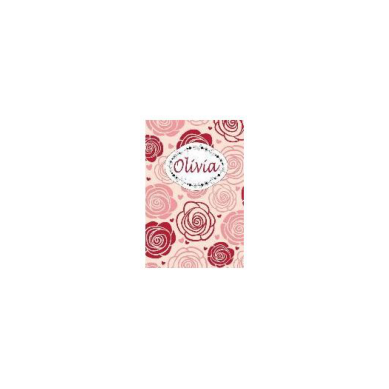

In [113]:
display_image(1263597046, 3804725264, "train")

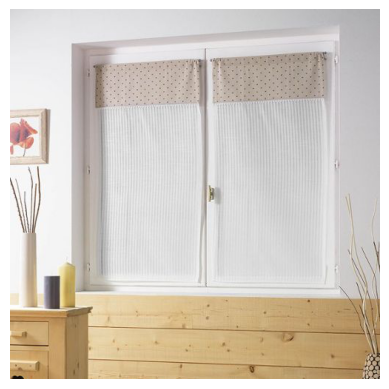

In [114]:
display_image(X_train.loc[13, "imageid"], X_train.loc[13, "productid"], "train")

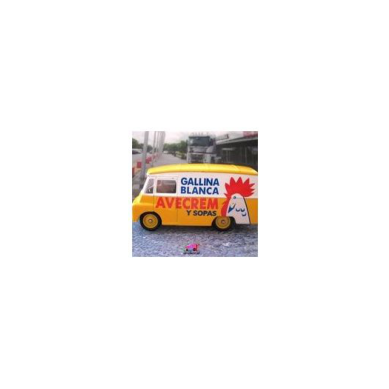

In [115]:
display_from(15, "test", is_index=False)

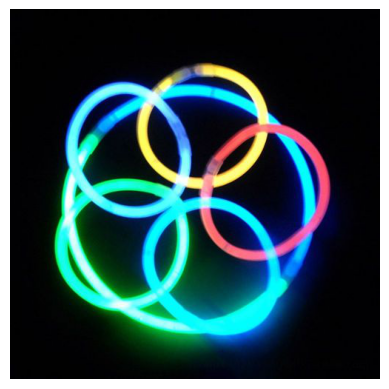

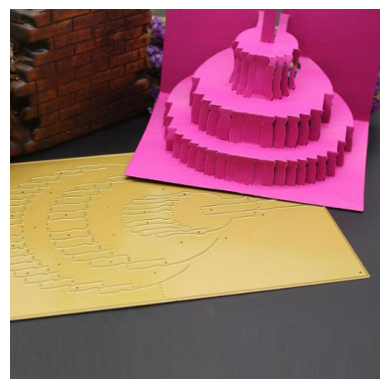

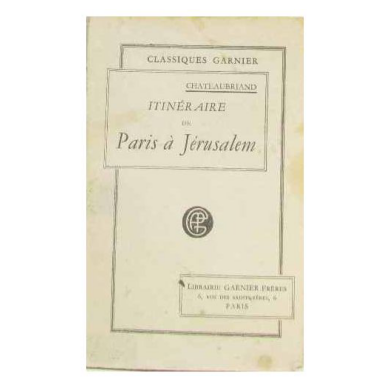

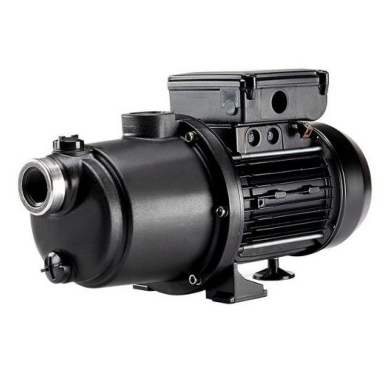

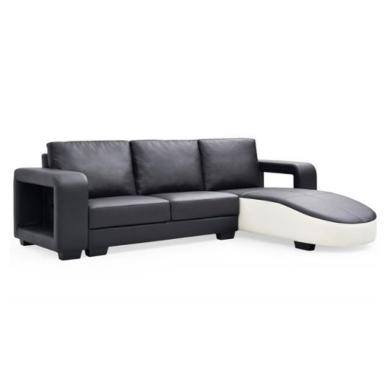

In [116]:
### Random images read with Matplotlib ###
for i in np.random.choice(np.arange(0, len(X_train)), size=5):
    display_from(i, "train", is_index=False)

# Stratégie envisagée suite à l'exploration des données

First option :

- Split X_train in two dataframes: one for training, the other for testing.
- Same with the same splitting for y_train.
- Create a model to classify the product from text including NLP on designation and description for - each product.
- Transform images to vectors, associated with products, to create a dataframe of pixels.
- Create a model to classify the product from images.
- Evaluate both models.
- Tune them or improve them.
- Define weights to both models according to their performances.
- Create a function to obtain a weighted average of probabilities for the best classes.
- Evaluate the results selecting the best class according to this weighted average along a testing - phase.
- Try to improve the results working on the weights.
- Compare the performance of these results with the best of the two initial models.
- Conclude on what solution (which model or which combination) would be better.

Utilitaires envisagés :

In [117]:
X_train["imagepath"] = X_train.apply(lambda row: image_path(row["imageid"], row["productid"], "train"), axis=1)
X_test["imagepath"] = X_test.apply(lambda row: image_path(row["imageid"], row["productid"], "test"), axis=1)

In [118]:
text_X_train = X_train[["designation", "description"]]
text_X_test = X_test[["designation", "description"]]

img_X_train = X_train["imagepath"]
img_X_test = X_test["imagepath"]